# Import dataset
Please get kaggle.json token from kagggle account to proceed
1. Create .kaggle directory in Google Drive
2. Upload kaggle.json token inside .kaggle folder

In [5]:
# Import Google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
! chmod 600 .kaggle/kaggle.json

In [1]:
# Import libraries and tools required

# For data manupulating
import os
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# For constructing deep network
import time
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
from torchsummary import summary
from tqdm import tqdm

# Evaluation methods
from sklearn.metrics import classification_report,confusion_matrix

# Setup device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
!pip install timm # kaggle doesnt have it installed by default

import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 8.9 MB/s 


#Load Data
- Using Data Loaders to load train, validation and test data


In [4]:
# Coded by <Chan Hong Wai, Khor Wei hong, Ivan Hn'g Zheng Quan>
############################################################################################
def get_loaders(directory, batch_size, train = False):

  # Imagenet average mean and std
  imgnet_mean = (0.485, 0.456, 0.406)
  imgnet_std = (0.229, 0.224, 0.225)

  # Perform pre-processing on dataset
  transform = transforms.Compose([
      transforms.Resize(256), # Resize to (256, 256)
      transforms.CenterCrop(224), # Cropped to (224, 224) to match input size
      transforms.ToTensor(), # Convert to tensor object
      transforms.Normalize(imgnet_mean, imgnet_std) # Normalize with Imagenet mean and std
  ])

  # Obtain dataset from different directory with transformation created
  train_set = datasets.ImageFolder((directory + "train/"), transform = transform)
  valid_set = datasets.ImageFolder((directory + "valid/"), transform = transform)
  test_set = datasets.ImageFolder((directory + "test/"), transform = transform)

  # Create loader shuffle = True for train while False for validation and test
  train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
  valid_loader = DataLoader(valid_set, batch_size = batch_size, shuffle = False, num_workers = 2)
  test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = False, num_workers = 2)

  # Return loader accordingly based on training stage/ validation and testing stage
  if train:
    return train_loader, len(train_set)  
  else:
    return valid_loader, len(valid_set), test_loader, len(test_set)
############################################################################################

In [6]:
dataset_directory = '/content/drive/MyDrive/'

train_batch_size = 128 # for train
test_batch_size = 32 # for validation and test

(train_loader, train_len) = get_loaders(dataset_directory, train_batch_size, True)
(valid_loader, valid_len, test_loader, test_len) = get_loaders(dataset_directory, test_batch_size, False)

In [7]:
# Use dictionaries to classified loaders and sizes
loaders = {
    "train": train_loader,
    "valid": valid_loader,
    "test": test_loader
}

sizes = {
    "train": train_len,
    "valid": valid_len,
    "test": test_len
}

In [8]:
# Adapted from https://www.kaggle.com/code/smartpy/vision-transformers
############################################################################################
# Get classes from datasets
def get_classes(directory):
    data = datasets.ImageFolder(directory)
    return data.classes
############################################################################################

In [9]:
# Coded by <Chan Hong Wai, Khor Wei hong, Ivan Hn'g Zheng Quan>
############################################################################################
# Print dataset overview
print("<Overview>")
total_classes = len(get_classes(dataset_directory + "train/"))
print("Total Classes:", total_classes)
print("Train set:", train_len)
print("Validation set:", valid_len)
print("Test set:", test_len)
############################################################################################

<Info>
Train set: 9285
Validation set: 375
Test set: 375
Total Classes: 75


#Construct ResNet
- Create Resblock as based building block
- Create ResNet based on Resblock
- Define Resnet network
- ResNet version would be Resnet34 with a total of 34 layers
- Layer architecture shown below

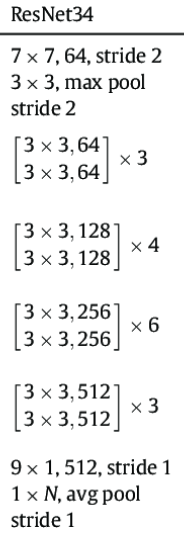

In [10]:
# Coded by <Chan Hong Wai, Khor Wei hong, Ivan Hn'g Zheng Quan>
############################################################################################
# Construct Residual Block
class ResBlock(nn.Module):
  exp = 1

  # Init function
  def __init__(self, in_channels, out_channels, downsample = None, stride = 1):
    super().__init__()

    # Build layers:[conv1 -> bn1 -> relu -> conv2 -> bn2] based on architecture
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.downsample = downsample
    self.stride = stride

  def forward(self, x):
    identity = x # identity = residual

    out = self.relu(self.bn1(self.conv1(x)))

    out = self.bn2(self.conv2(out))

    if self.downsample is not None:
      identity = self.downsample(x) # Downsample when self.downsample is not None

    out += identity # Sum the residual and output
    
    return self.relu(out) # Return output after perform ReLU activation
############################################################################################

In [11]:
# Check if nothing wrong for Resblock
ResBlock(64, 128)

ResBlock(
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [12]:
from torch.nn.modules.pooling import MaxPool2d

# Create ResNet
class ResNet(nn.Module):
  def __init__(self, Resblock, layers_list, num_classes = total_classes):
    super().__init__() # override __init__()
    out_channels = [64, 128, 256, 512] # list of out_channels
    self.in_channels = 64 # initialize in_channels
    
    # Construct first layer (layer 0): [conv -> bn -> relu -> maxpool]
    self.layer0 = nn.Sequential(
        nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False),
        nn.BatchNorm2d(self.in_channels),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
    )

    # Create 4 layers with create_layer function
    self.layer1 = self.create_layer(Resblock, layers_list[0], channel = out_channels[0])
    self.layer2 = self.create_layer(Resblock, layers_list[1], channel = out_channels[1], stride = 2)
    self.layer3 = self.create_layer(Resblock, layers_list[2], channel = out_channels[2], stride = 2)
    self.layer4 = self.create_layer(Resblock, layers_list[3], channel = out_channels[3], stride = 2)

    # Classification layer
    self.gap = nn.AdaptiveAvgPool2d((1,1)) # Perform Average Pooling
    self.fc = nn.Linear(out_channels[3], num_classes) # Fully connected layer with linear activation 

  # Forward propagation
  def forward(self, x):
    x = self.layer0(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.gap(x)
    x = torch.flatten(x, 1) # Flatten to 1D array for fc layer
    x = self.fc(x)

    return x
  #Adapted from https://www.kaggle.com/code/poonaml/building-resnet34-from-scratch-using-pytorch/notebook
  ############################################################################################
  # Helper function to create layer
  def create_layer(self, Resblock, num_blocks, out_c, stride = 1):
    downsample = None
    
    # If stride != 1, where downsampling is needed
    if stride != 1 or self.in_channels != out_c:
      downsample = nn.Sequential(
          nn.Conv2d(self.in_channels, out_c, 1, stride, bias = False),
          nn.BatchNorm2d(out_c)
      )

    # Create layer
    layers = []
    layers.append(Resblock(self.in_channels, out_c, downsample, stride = stride))
    self.in_channels = out_c

    for i in range(1, num_blocks):
      layers.append(Resblock(self.in_channels, out_c))

    return nn.Sequential(*layers) # Return layer created
  ############################################################################################

In [13]:
# Define ResNet34
def resnet34():
  model = ResNet(ResBlock, [3, 4, 6, 3])
  return model

In [14]:
model = resnet34()
#summary(model, (3, 224, 224))

In [15]:
# Check models
list(models.resnet34().children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

#Training

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Coded by <Chan Hong Wai, Khor Wei hong, Ivan Hn'g Zheng Quan>
############################################################################################
import copy

def train(model, criterion, optimizer, scheduler, num_epochs):
  start = time.time()
  print("Starting...")

  best_acc = 0.0
  best_model_params = copy.deepcopy(model.state_dict())

  for epoch in range(num_epochs):
    print(f"[EPOCH {epoch + 1}/{num_epochs}]")
    print()

    # Train and validation phase occurs simultaneously
    for stg in ['train', 'valid']:
      if stg == 'train':
        scheduler.step()     
        model.train() 
      else:
         model.eval()
      
      running_corrects = 0.0
      running_loss = 0.0
      
      # Iterate over train data
      for inputs, targets in tqdm(loaders[stg]):
        inputs, targets = inputs.to(device), targets.to(device) # Set to GPU

        # Reset parameters gradient
        optimizer.zero_grad()

        # Set_grad_enabled only when train stage
        with torch.set_grad_enabled(stg == 'train'): 

          # forward
          model = model.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)
          loss = criterion(outputs, targets)
          print(" {} loss : {:.4f}".format(stg, loss.item()))

          # backward and optimize (update params) only if train stage
          if stg == 'train':
            loss.backward()
            optimizer.step()

          # Calculate running_corrects
          running_corrects += torch.sum(predicted == targets.data).to(torch.float32)
          running_loss += loss.item() * inputs.size(0)  

      # Compute epoch accuracy and loss
      ep_loss = running_loss/sizes[stg]
      ep_acc = running_corrects/sizes[stg] * 100 

      print("\n [{} Epoch Loss : {:.4f}]".format(stg, ep_loss))
      print("\n [valid Epoch Accuracy : {:.2f}]\n".format(ep_acc)) if stg == 'valid' else print("[valid Epoch Accuracy : N/A]\n")

      # Update best accuracy and best_params in validation stage
      if stg == 'valid' and ep_acc > best_acc:
        best_acc = ep_acc
        best_model_params = copy.deepcopy(model.state_dict())
    
    print()

  fin = time.time()
  elapsed = fin - start
  print("\nBest Accuracy recorded -> {:.2f}%".format(best_acc))
  print("Training finished in {:.0f}m {:.0f}s".format(elapsed // 60, elapsed % 60))
  
  # Load the best model
  model.load_state_dict(best_model_params)
  # Save the parameters
  torch.save(model.state_dict(), dataset_directory + "param1")

  return model
############################################################################################

In [17]:
# Parameters
num_classes = total_classes
learning_rate = 0.001
num_epochs = 2

criterion = LabelSmoothingCrossEntropy().to(device) # Loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Optimizer algorithm
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97) # Learning rate scheduler

In [ ]:
# Finetuned model can be tuned repeatly
#model.load_state_dict(torch.load(dataset_directory + "param1")) (uncomment if need to load state_dict() from drive)
finetuned_model = train(model, criterion, optimizer, exp_lr_scheduler, num_epochs)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Starting...
[EPOCH 1/2]



  0%|          | 0/73 [00:00<?, ?it/s]

 train loss : 4.4534


  1%|▏         | 1/73 [01:48<2:09:37, 108.02s/it]

 train loss : 5.3249


  3%|▎         | 2/73 [02:43<1:31:20, 77.19s/it] 

 train loss : 4.6817


  4%|▍         | 3/73 [03:49<1:24:02, 72.03s/it]

 train loss : 5.3788


  5%|▌         | 4/73 [04:52<1:18:45, 68.49s/it]

 train loss : 4.5399


  7%|▋         | 5/73 [05:51<1:13:51, 65.17s/it]

 train loss : 4.4718


  8%|▊         | 6/73 [06:57<1:12:50, 65.23s/it]

 train loss : 4.6684


 10%|▉         | 7/73 [07:54<1:08:44, 62.49s/it]

 train loss : 4.4146


 11%|█         | 8/73 [08:53<1:06:43, 61.60s/it]

 train loss : 4.3412


 12%|█▏        | 9/73 [09:47<1:03:03, 59.11s/it]

 train loss : 4.2368


 14%|█▎        | 10/73 [10:53<1:04:11, 61.13s/it]

 train loss : 4.1674


 15%|█▌        | 11/73 [12:04<1:06:32, 64.40s/it]

 train loss : 4.1775


 16%|█▋        | 12/73 [13:08<1:05:06, 64.04s/it]

 train loss : 4.1411


 18%|█▊        | 13/73 [14:15<1:05:08, 65.14s/it]

 train loss : 4.0115


 19%|█▉        | 14/73 [15:23<1:04:51, 65.95s/it]

 train loss : 3.9656


 21%|██        | 15/73 [16:28<1:03:20, 65.53s/it]

 train loss : 4.0533


 22%|██▏       | 16/73 [17:26<1:00:18, 63.48s/it]

 train loss : 3.9550


 23%|██▎       | 17/73 [18:26<58:02, 62.19s/it]  

 train loss : 3.9178


 25%|██▍       | 18/73 [19:23<55:34, 60.62s/it]

 train loss : 3.9198


 26%|██▌       | 19/73 [20:16<52:42, 58.57s/it]

 train loss : 3.8769


 27%|██▋       | 20/73 [21:13<51:07, 57.87s/it]

 train loss : 3.8502


 29%|██▉       | 21/73 [22:19<52:29, 60.57s/it]

 train loss : 3.9277


 30%|███       | 22/73 [23:23<52:14, 61.45s/it]

 train loss : 3.9086


 32%|███▏      | 23/73 [24:37<54:24, 65.30s/it]

 train loss : 3.8659


 33%|███▎      | 24/73 [25:42<53:12, 65.14s/it]

 train loss : 3.7495


 34%|███▍      | 25/73 [27:03<55:59, 69.98s/it]

 train loss : 3.7596


 36%|███▌      | 26/73 [28:16<55:24, 70.74s/it]

 train loss : 3.5178


 37%|███▋      | 27/73 [29:21<52:54, 69.01s/it]

 train loss : 3.5709


 38%|███▊      | 28/73 [30:15<48:28, 64.64s/it]

 train loss : 3.5342


 40%|███▉      | 29/73 [31:20<47:21, 64.58s/it]

 train loss : 3.7837


 41%|████      | 30/73 [32:18<44:57, 62.74s/it]

 train loss : 3.7785


 42%|████▏     | 31/73 [33:20<43:48, 62.59s/it]

 train loss : 3.6634


 44%|████▍     | 32/73 [34:20<42:10, 61.72s/it]

 train loss : 3.4927


 45%|████▌     | 33/73 [35:20<40:51, 61.30s/it]

 train loss : 3.6818


 47%|████▋     | 34/73 [36:22<39:57, 61.47s/it]

 train loss : 3.6310


 48%|████▊     | 35/73 [37:28<39:44, 62.75s/it]

 train loss : 3.6427


 49%|████▉     | 36/73 [38:25<37:41, 61.13s/it]

 train loss : 3.4865


 51%|█████     | 37/73 [39:20<35:35, 59.31s/it]

 train loss : 3.6051


 52%|█████▏    | 38/73 [40:17<34:12, 58.63s/it]

 train loss : 3.4819


 53%|█████▎    | 39/73 [41:15<33:05, 58.41s/it]

 train loss : 3.5257


 55%|█████▍    | 40/73 [42:21<33:20, 60.61s/it]

 train loss : 3.5358


 56%|█████▌    | 41/73 [43:25<32:48, 61.53s/it]

 train loss : 3.4723


 58%|█████▊    | 42/73 [44:29<32:15, 62.45s/it]

 train loss : 3.3909


 59%|█████▉    | 43/73 [45:27<30:30, 61.02s/it]

 train loss : 3.3144


 60%|██████    | 44/73 [46:31<29:56, 61.93s/it]

 train loss : 3.5233


 62%|██████▏   | 45/73 [47:30<28:30, 61.09s/it]

 train loss : 3.3329


 63%|██████▎   | 46/73 [48:40<28:43, 63.83s/it]

 train loss : 3.2803


 64%|██████▍   | 47/73 [49:42<27:23, 63.22s/it]

 train loss : 3.5035


 66%|██████▌   | 48/73 [50:41<25:48, 61.92s/it]

 train loss : 3.3409


 67%|██████▋   | 49/73 [51:39<24:16, 60.68s/it]

 train loss : 3.5590


 68%|██████▊   | 50/73 [52:41<23:26, 61.14s/it]

 train loss : 3.4426


 70%|██████▉   | 51/73 [53:40<22:08, 60.38s/it]

 train loss : 3.3659


 71%|███████   | 52/73 [54:55<22:44, 64.96s/it]

 train loss : 3.3835


 73%|███████▎  | 53/73 [55:58<21:26, 64.31s/it]

 train loss : 3.2539


 74%|███████▍  | 54/73 [57:03<20:26, 64.54s/it]

 train loss : 3.2526


 75%|███████▌  | 55/73 [58:02<18:48, 62.71s/it]

 train loss : 3.3438


 77%|███████▋  | 56/73 [59:00<17:23, 61.38s/it]

 train loss : 3.2389


 78%|███████▊  | 57/73 [59:56<15:58, 59.93s/it]

 train loss : 3.3013


 79%|███████▉  | 58/73 [1:00:51<14:36, 58.43s/it]

 train loss : 3.1599


#Testing

In [ ]:
# Adapted from https://www.kaggle.com/code/pdochannel/swin-transformer-in-pytorch
############################################################################################
test_classes = get_classes(dataset_directory + "test/")

predicted_ls = []
actual_ls = []

class_predicted_num = list(0 for i in range(sizes['test']))
class_total_num = list(0 for i in range(sizes['test']))

# Set model to eval() mode
finetuned_model.eval()

# Load data and change to GPU
for inputs, targets in tqdm(loaders['test']):
    inputs, targets = inputs.to(device), targets.to(device)
    actual_ls.append(targets.cpu().numpy()) # Get label

    # With no grad enabled, testing will be faster
    with torch.set_grad_enabled(False): 
        finetuned_model = finetuned_model.to(device) # Change to GPU

        # forward
        output = finetuned_model(inputs)
        _, predicted = torch.max(output, 1)
        predicted_ls.append(predicted.cpu().numpy()) # Get pred
    
    # Change and squeeze tensor to numpy array where the predicted is same as predicted in data with the same view
    predicted_tensor = predicted.eq(targets.data.view_as(predicted))
    pred = np.squeeze(predicted_tensor.cpu().numpy())
    
    # If target length equals test batch size
    if len(targets) == test_batch_size:
        for i in range(test_batch_size):
            target = targets.data[i]
            class_predicted_num[target] += pred[i].item()
            class_total_num[target] += 1

# Modify actual and pred
act = np.concatenate(actual_ls)
pdt = np.concatenate(predicted_ls)

# Accuracy
print("Accuracy for Test Classes :")
for i in range(len(test_classes)):
    if class_total_num[i] > 0:
        print("%5s: %2d%%" % (test_classes[i], 100*class_predicted_num[i]/class_total_num[i]))
    else:
        print("%5s: None" % (test_classes[i]))

print()
print("Total Test Accuracy: %2d%%  Total classes predicted: (%2d/%2d)" % (100*np.sum(class_predicted_num)/np.sum(class_total_num), np.sum(class_predicted_num), np.sum(class_total_num)))
############################################################################################

#Evaluation Metrics

In [ ]:
# Coded by <Chan Hong Wai, Khor Wei hong, Ivan Hn'g Zheng Quan>
############################################################################################
# Display "Actual vs Predictions" for some sample test set
def displayPred(test_set, num_img):
    fig, ax = plt.subplots(figsize=[25,30])
    for i in range(num_img):
      image,_ = test_set[i]
      ax = plt.subplot(10,5,i+1) 
      ax = plt.imshow(image)
      ax = plt.xlabel(f"Actual : {test_classes[act[i]]}\n Predicted : {test_classes[pdt[i]]}")
      ax = plt.xticks([])
      ax = plt.yticks([])
      ax = plt.suptitle('Actual vs Predictions', fontsize = 30)
    plt.show()
############################################################################################

In [ ]:
test_set = datasets.ImageFolder((dataset_directory + "test/"), )

num_img = 50
displayPred(test_set, num_img)

In [ ]:
# Construct confusion matrix
fig, ax = plt.subplots(figsize = (25, 15))
ax.set_title('Confusion Matrix'); 

sns.heatmap(confusion_matrix(pdt, act),
            annot = True, 
            fmt = "d", 
            ax = ax,
            cmap = "inferno")

In [ ]:
# Construct Classification Report
print(classification_report(pdt, act))